In [8]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [51]:
%cd /content/drive/MyDrive/bm_proj

/content/drive/.shortcut-targets-by-id/1gTYl2j4owRbvoTWA53HcUOnrXZk8QjZU/bm_proj


In [3]:
#!pip install split-folders[full]

# Environment

In [42]:
import torch
from torch.functional import Tensor
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchsummary import summary

import torchvision
from torchvision import datasets, models
import torchvision.transforms as transforms

from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay,
    precision_recall_fscore_support)

import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt

import os

import tqdm
from tqdm.auto import tqdm

#import splitfolders


In [43]:
dev = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# Data

In [53]:
%cd /content/drive/MyDrive/bm_proj/images

/content/drive/.shortcut-targets-by-id/1gTYl2j4owRbvoTWA53HcUOnrXZk8QjZU/bm_proj/images


In [7]:
#splitfolders.ratio('.', output="output", seed=1337, ratio=(.5, 0.2, 0.3))

Ratio is approx 3:1:2 in coherence with the original paper.

In [48]:
IMG_MEAN = [123.675, 116.28, 103.53]
IMG_STD = [58.395, 57.12, 57.375]

train_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.Resize((512, 512)),
    transforms.Normalize(mean=IMG_MEAN, std=IMG_STD)
    ])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((512, 512)),
    transforms.Normalize(mean=IMG_MEAN, std=IMG_STD)
    ])

img_norm values from original code.

In [ ]:
'''
print(len(os.listdir('output/train/health')))
print(len(os.listdir('output/val/health')))
print(len(os.listdir('output/test/health')))
'''

In [50]:
BATCH_SIZES = [8, 16, 32, 64, 128]

train_dataset = torchvision.datasets.ImageFolder(root='output/train', transform=train_transform)
train_loader = DataLoader(train_dataset,
                          batch_size=BATCH_SIZES[1],
                          shuffle=True
                          )

val_dataset = torchvision.datasets.ImageFolder(root='output/val', transform=test_transform)
val_loader = DataLoader(val_dataset,
                        batch_size=BATCH_SIZES[3],
                        shuffle=False)

test_dataset = torchvision.datasets.ImageFolder(root='output/test', transform=test_transform)
test_loader = DataLoader(test_dataset,
                         batch_size=BATCH_SIZES[3],
                         shuffle=True)

#Model

In [38]:
model = models.resnet50(weights='IMAGENET1K_V1').to(dev)

#summary(model, (3, 512, 512))

In [40]:
weights = torch.load('/content/drive/MyDrive/bm_proj/saved_model2.pth', map_location=torch.device(dev))
#print(weights.keys())

In [41]:
classes = 'health', 'sick', 'tb'
n_classes = len(classes)
model.fc = nn.Linear(2048, n_classes, bias=True)

for name, param in model.named_parameters():
    if 'layer4.2' in name or 'fc' in name:
        param = weights[name]
        param.requires_grad = True
    else:
        #print(name)
        param.requires_grad = False #freeze

#summary(model.to(dev), (3, 512, 512))


# Optimizer and other variables

In [56]:
lr=0.0001

optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=0.0005)

criterion = nn.CrossEntropyLoss()


# Training and Validation

In [46]:
model = model.to(dev)

In [30]:
def train(model, trainloader, optimizer, criterion):
    counter = 0
    cum_loss = 0.00
    cum_correct = 0
    cum_samples = 0

    model.train()

    for inputs, targets in tqdm(trainloader):
        targets = targets.type(torch.LongTensor)
        inputs, targets = inputs.to(dev), targets.to(dev)

        optimizer.zero_grad()
        outputs = model(inputs)

        loss = criterion(outputs.squeeze(), targets.squeeze())
        cum_loss += loss

        _, predicted = torch.max(outputs, 1)
        cum_correct += (predicted == targets).sum().item()
        cum_samples += targets.size(0)

        loss.backward()
        optimizer.step()

        counter += 1

    epoch_loss = cum_loss / counter
    epoch_accu = cum_correct / cum_samples
    return epoch_loss, epoch_accu

In [17]:
def val(model, valloader, criterion):
    counter = 0
    cum_loss = 0.00
    cum_correct = 0
    cum_samples = 0

    model.eval()

    with torch.no_grad():
        for inputs, targets in tqdm(valloader):
            targets = targets.type(torch.LongTensor)
            inputs, targets = inputs.to(dev), targets.to(dev)

            outputs = model(inputs)

            loss = criterion(outputs.squeeze(), targets.squeeze())
            cum_loss += loss

            _, predicted = torch.max(outputs, 1)
            cum_correct += (predicted == targets).sum().item()
            cum_samples += targets.size(0)

            counter += 1

    epoch_loss = cum_loss / counter
    epoch_accu = cum_correct / cum_samples
    return epoch_loss, epoch_accu

In [57]:
NUM_EPOCHS = 3
train_losses = []
train_accus = []
val_losses = []
val_accus = []

for epoch in range(NUM_EPOCHS):
    print(f"\nTraining epoch {epoch + 1}/{NUM_EPOCHS}: ")
    epoch_loss, epoch_accu = train(model, train_loader, optimizer, criterion)
    train_losses.append(float(epoch_loss))
    train_accus.append(float(epoch_accu))
    print(f"Training loss: {epoch_loss:.6f}")
    print(f"Training accuracy: {epoch_accu:.6f} \n")

    print(' Validating...')
    epoch_loss, epoch_accu = val(model, val_loader, criterion)
    val_losses.append(float(epoch_loss))
    val_accus.append(float(epoch_accu))
    print(f"Validation loss: {epoch_loss:.6f}")
    print(f"Validation accuracy: {epoch_accu:.6f} \n")


Training epoch 1/3: 


  0%|          | 0/210 [00:00<?, ?it/s]

Training loss: 0.304757
Training accuracy: 0.896905 

 Validating...


  0%|          | 0/27 [00:00<?, ?it/s]

Validation loss: 0.286187
Validation accuracy: 0.915476 


Training epoch 2/3: 


  0%|          | 0/210 [00:00<?, ?it/s]

Training loss: 0.290820
Training accuracy: 0.907619 

 Validating...


  0%|          | 0/27 [00:00<?, ?it/s]

Validation loss: 0.279217
Validation accuracy: 0.919643 


Training epoch 3/3: 


  0%|          | 0/210 [00:00<?, ?it/s]

Training loss: 0.292012
Training accuracy: 0.905476 

 Validating...


  0%|          | 0/27 [00:00<?, ?it/s]

Validation loss: 0.276276
Validation accuracy: 0.922619 



In [58]:
torch.save(model.state_dict(), '/content/drive/MyDrive/bm_proj/saved_model3.pth')

In [5]:
%cd /content/drive/MyDrive/bm_proj/plots

/content/drive/.shortcut-targets-by-id/1gTYl2j4owRbvoTWA53HcUOnrXZk8QjZU/bm_proj/plots


In [60]:
import csv
from itertools import zip_longest

with open('loss_and_accu_3rdrun.csv', 'a') as f:

    write = csv.writer(f)

    #fields = ['train_losses', 'val_losses', 'train_accus', 'val_accus']

    lists = [train_losses, val_losses, train_accus, val_accus]
    columns_data = zip_longest(*lists)

    #write.writerow(fields)
    write.writerows(columns_data)

In [ ]:
'''
x = range(1, NUM_EPOCHS+1)
fig, axes = plt.subplots(2, 1, figsize=(10, 10))
plt.xticks(np.arange(1, NUM_EPOCHS+1, 1))

axes[0].plot(x, train_losses, label="Training")
axes[0].plot(x, val_losses, label="Validation")
axes[0].title.set_text('Loss')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Loss')
axes[0].legend()

axes[1].plot(x, train_accus, label="Training")
axes[1].plot(x, val_accus, label="Validation")
axes[1].title.set_text('Accuracy')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Accuracy')
axes[1].legend()

#plt.savefig('2ndrun_7epoches.png')

plt.show()
'''

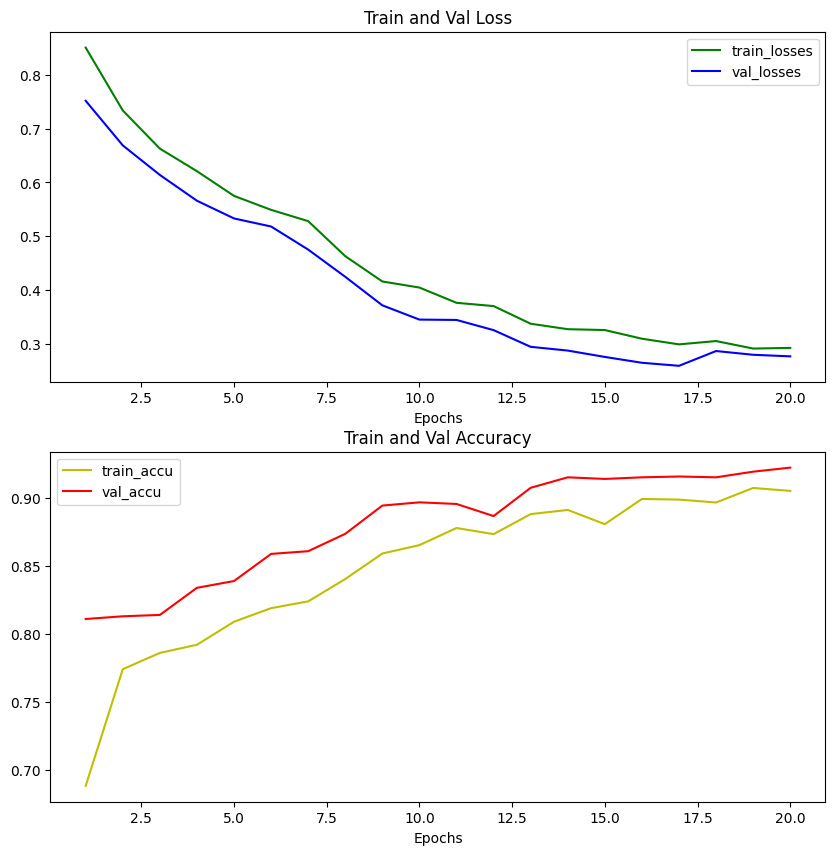

In [39]:
import pandas as pd

df = pd.read_csv("/content/drive/MyDrive/bm_proj/plots/loss_and_accu_20epochs.csv")


x = range(1, 20+1)

fig, axes = plt.subplots(2, 1, figsize=(10, 10))

x_data = x
y_data1 = df['train_losses']
y_data2 = df['val_losses']

# Plot the data
axes[0].plot(x_data, y_data1, label='train_losses', color='g')
axes[0].plot(x_data, y_data2, label='val_losses', color='b')
axes[0].set_xlabel('Epochs')
axes[0].set_title('Train and Val Loss')

axes[0].legend()

y_data2 = df['train_accus']
y_data3 = df['val_accus']

axes[1].plot(x_data, y_data2, label='train_accu', color='y')
axes[1].plot(x_data, y_data3, label='val_accu', color='r')
axes[1].set_xlabel('Epochs')
axes[1].set_title('Train and Val Accuracy')

axes[1].legend()

plt.savefig('20epochs.png')

# Show the plot
plt.show()

# Testing

In [47]:
def test(model, testloader):
    cum_correct = 0
    cum_samples = 0
    i = 0

    y_pred = []
    y_true = []

    model.eval()

    with torch.no_grad():
        for inputs, targets in tqdm(testloader):
            #if i == 5: break

            targets = targets.type(torch.LongTensor)
            inputs, targets = inputs.to(dev), targets.to(dev)

            outputs = model(inputs)

            _, predicted = torch.max(outputs, 1)
            cum_correct += (predicted == targets).sum().item()
            cum_samples += targets.size(0)

            y_pred.extend(predicted.tolist()) # Save Prediction
            y_true.extend(targets.tolist()) # Save Truth

            i+=1

    accu = cum_correct / cum_samples
    return accu, y_pred, y_true

In [65]:
print(' Testing...')
accu, y_pred, y_true = test(model, test_loader)
print(accu)


 Testing...


  0%|          | 0/40 [00:00<?, ?it/s]

0.9206349206349206


In [ ]:
'''
print(y_true[:10])
print(y_pred[:10])
'''

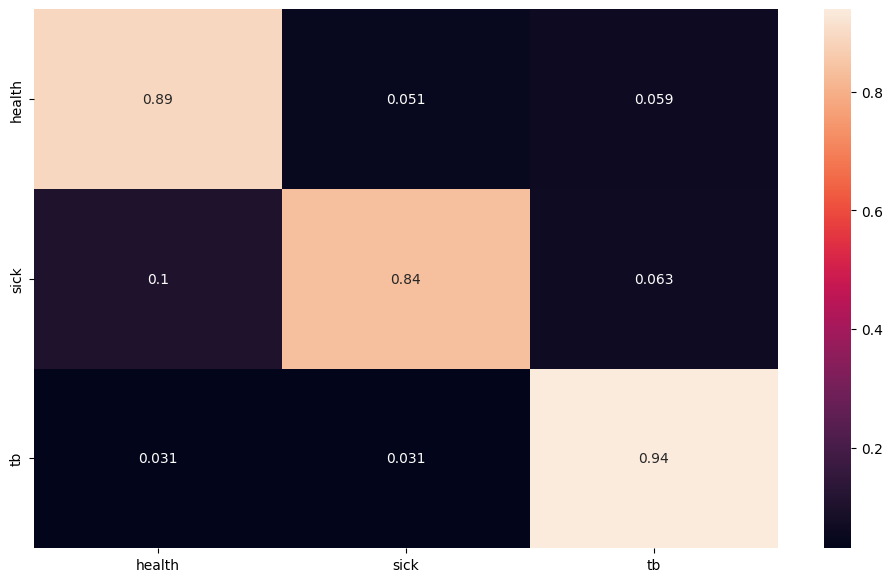

In [37]:
import seaborn as sn
import pandas as pd

cf_matrix = confusion_matrix(y_pred, y_true)
df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None], index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (12,7))
sn.heatmap(df_cm, annot=True)
plt.savefig('output.png')